In [169]:
%cd "/home/jspijkervet/git/clmr/"
!python --version

/home/jspijkervet/git/clmr
Python 3.7.4


In [170]:
# import sys
# sys.path.append("./scikit-learn")

In [171]:
import os
import torch
import torchaudio
import numpy as np
from collections import defaultdict
from utils import parse_args
from data import get_dataset
from model import load_encoder

In [172]:
args = parse_args("./config/config.yaml", addit=[])
args.world_size = 1
args.supervised = False
args.dataset = "msd"
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

args.model_path = "./logs/66"
args.epoch_num = 10000
args.finetune_model_path = "./results/66"
args.finetune_epoch_num = 500

In [175]:
# data loaders
(
    train_loader,
    train_dataset,
    val_loader,
    val_dataset,
    test_loader,
    test_dataset,
) = get_dataset(args, pretrain=True, download=args.download)

[train dataset (msd_22050)]
[million_song_dataset train]: Loaded 201676 audio segments
[valid dataset (msd_22050)]
[million_song_dataset valid]: Loaded 11774 audio segments
[test dataset (msd_22050)]
[million_song_dataset test]: Loaded 28434 audio segments


In [176]:
# load pre-trained encoder
encoder = load_encoder(args, reload=True)
encoder.eval()
encoder = encoder.to(args.device)

model = None
if not args.supervised:
    finetuned_head = torch.nn.Sequential(
        torch.nn.Linear(args.n_features, args.n_classes)
    )

    finetuned_head.load_state_dict(
        torch.load(
            os.path.join(
                args.finetune_model_path,
                f"finetuner_checkpoint_{args.finetune_epoch_num}.pt",
            )
        )
    )
    finetuned_head = finetuned_head.to(args.device)

# initialize TensorBoard

args.current_epoch = args.epoch_num

### SampleCNN ###
### RELOADING CLMR MODEL FROM CHECKPOINT 10000 ###


## Inference

In [177]:
tag_classes = defaultdict(list)
predictions = []
n = 100 # add every n
with torch.no_grad():
    for step, (track_id, clip_id, segment, fp, label) in enumerate(test_dataset.index):
        if step % n == 0:
            audio = test_dataset.get_full_size_audio(fp)
            audio = audio.to(args.device)
            h = encoder(audio)
            output = finetuned_head(h)
            output = torch.nn.functional.softmax(output, dim=1)

            h = h.mean(dim=0)
            output = output.mean(dim=0) # take mean predictions of whole track, i.e., over batch dim.
            predictions.append([output.cpu().numpy().tolist(), h.cpu().numpy().tolist(), track_id, clip_id, segment, fp, label])

            print(step, "/", len(test_dataset))        

0 / 28434
100 / 28434
200 / 28434
300 / 28434
400 / 28434
500 / 28434
600 / 28434
700 / 28434
800 / 28434
900 / 28434
1000 / 28434
1100 / 28434
1200 / 28434
1300 / 28434
1400 / 28434
1500 / 28434
1600 / 28434
1700 / 28434
1800 / 28434
1900 / 28434
2000 / 28434
2100 / 28434
2200 / 28434
2300 / 28434
2400 / 28434
2500 / 28434
2600 / 28434
2700 / 28434
2800 / 28434
2900 / 28434
3000 / 28434
3100 / 28434
3200 / 28434
3300 / 28434
3400 / 28434
3500 / 28434
3600 / 28434
3700 / 28434
3800 / 28434
3900 / 28434
4000 / 28434
4100 / 28434
4200 / 28434
4300 / 28434
4400 / 28434
4500 / 28434
4600 / 28434
4700 / 28434
4800 / 28434
4900 / 28434
5000 / 28434
5100 / 28434
5200 / 28434
5300 / 28434
5400 / 28434
5500 / 28434
5600 / 28434
5700 / 28434
5800 / 28434
5900 / 28434
6000 / 28434
6100 / 28434
6200 / 28434
6300 / 28434
6400 / 28434
6500 / 28434
6600 / 28434
6700 / 28434
6800 / 28434
6900 / 28434
7000 / 28434
7100 / 28434
7200 / 28434
7300 / 28434
7400 / 28434
7500 / 28434
7600 / 28434
7700 / 2843

In [195]:
# for website
ds = []
for idx, a in enumerate(predictions):
    preds_finetuned = a[0]
    preds_encoder = a[1]

    d = {}

    # for faster loading in web browser
    mp3_fp = os.path.splitext(a[5])[0] + ".wav"
#     if not os.path.exists(mp3_fp):
#         audio, sr = torchaudio.load(a[5])
#         torchaudio.save(mp3_fp, audio, sr)

    d["idx"] = idx
    d["audio"] = mp3_fp

    for ix, p in enumerate(preds_finetuned):
        d[test_dataset.tags[ix]] = p
    for ix, p in enumerate(preds_encoder):
        d[ix] = p

    d["track_id"] = a[2]
    d["clip_id"]= a[3]
    d["segment"] = a[4]

    d["labels"] = []
    for label_id, has_label in enumerate(a[6]):
        if has_label:
            d["labels"].append(test_dataset.tags[label_id])
    ds.append(d)
#     print(idx, "/", len(predictions))

import json
with open("./web/latent_listening/predictions.json", "w") as f:
    json.dump(ds, f)

In [179]:
TAG_NUM = 0
tag = train_dataset.tags[TAG_NUM]
tag_sort = sorted(predictions, key=lambda x: x[0][TAG_NUM], reverse=True)
print("Showing for tag:", tag)

Showing for tag: rock


In [180]:
# import IPython.display as ipd
# for idx, (pred, _, _, segment, fp, _) in enumerate(tag_sort):
#     if idx % 200 == 0:
#         print(segment)
#         ipd.display(ipd.Audio(fp, rate=args.sample_rate))
        

In [181]:
FEATURE_NUM = 1
tag = train_dataset.tags[FEATURE_NUM]
feature_sort = sorted(predictions, key=lambda x: x[1][FEATURE_NUM], reverse=True)

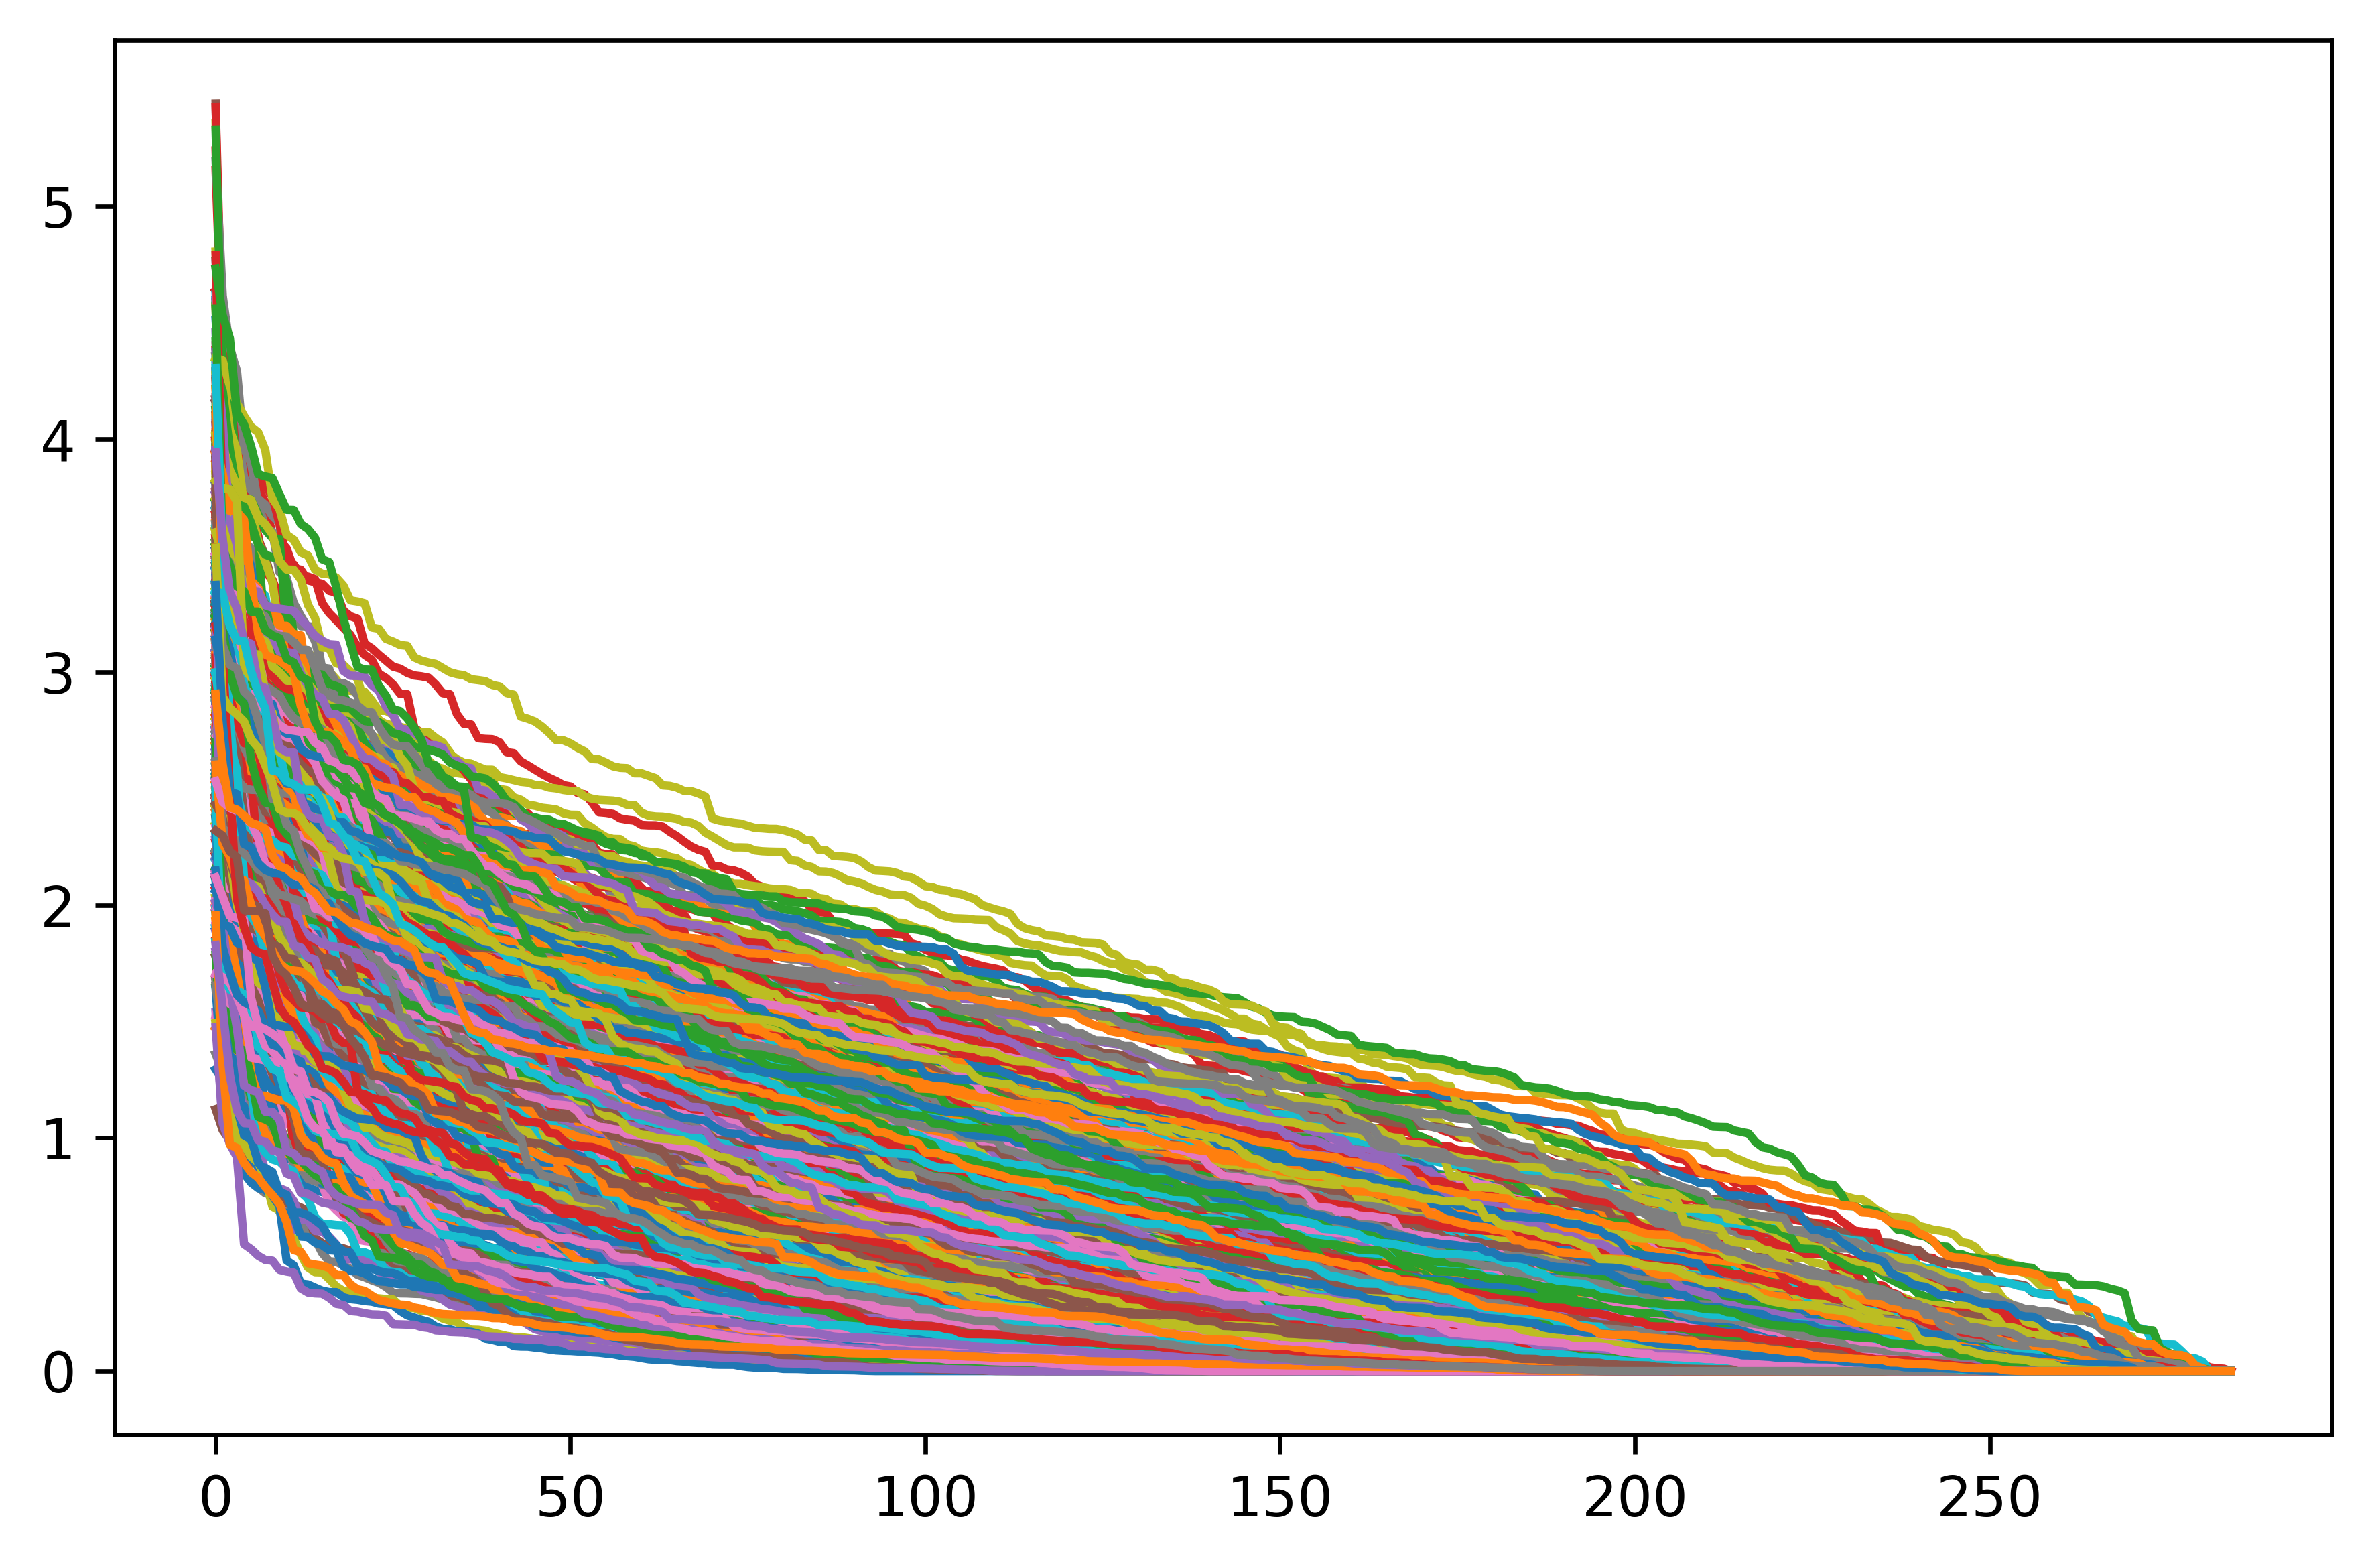

In [184]:
import matplotlib.pyplot as plt
figure = plt.figure(dpi=600)

for feature_num in range(0, 512):
    s = sorted(predictions, key=lambda x: x[1][feature_num], reverse=True)
    features = [f[1][feature_num] for f in s]
    plt.plot(features)
    
# plt.title("Activations of each feature")
# plt.xlabel("Track num")
# plt.ylabel("Activation")
plt.tight_layout()
plt.savefig("./media/activations_msd.pdf")
plt.show()

## Correlation

In [183]:
prediction_matrix = [p[1] for p in predictions]
print(len(prediction_matrix[0]))

prediction_matrix = np.array(prediction_matrix)
feature_names = [c for c in range(len(prediction_matrix[0]))] # data["feature_names"]

512


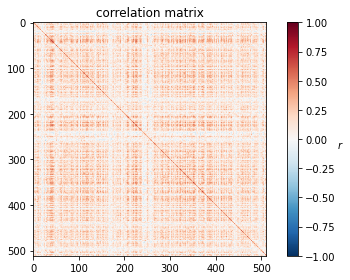

In [185]:
ax = plt.axes()

im = ax.imshow(np.corrcoef(prediction_matrix.T), cmap="RdBu_r", vmin=-1, vmax=1)

plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
ax.set_title("correlation matrix")
plt.tight_layout()

## Factor Analysis

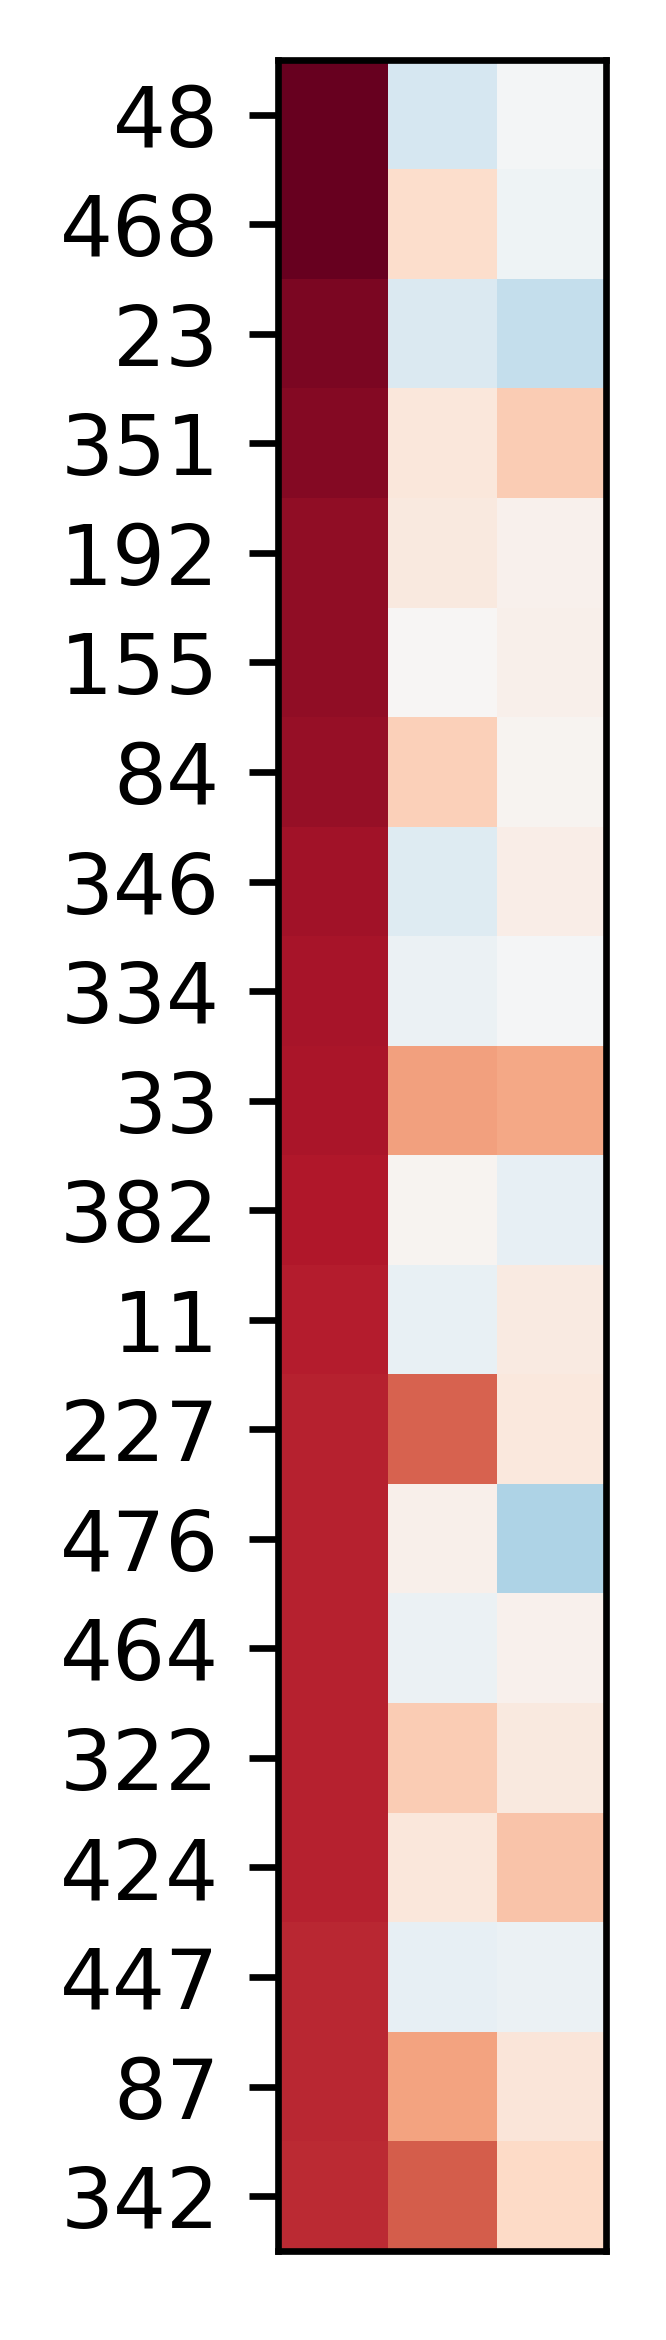

In [188]:
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

n_comps = 3
SORT_BY_COMP_N = 0

# #############################################################################
# Run factor analysis with Varimax rotation
fig, ax = plt.subplots(dpi=600)

method = "varimax"
fa = FactorAnalysis(n_components=n_comps, rotation=method).fit(prediction_matrix)
components = fa.components_.T
# print(method, ":\n", components, end="\n\n")


vmax = np.abs(components).max()

comps = {k: v for k, v in zip(feature_names, components)}
# components = {k: v for k, v in comps.items()} # sorted(comps.items(), key=lambda item: item[1][0], reverse=True)}
components = {k: v for k, v in sorted(comps.items(), key=lambda item: item[1][SORT_BY_COMP_N], reverse=True)}

components = {k: v for idx, (k, v) in enumerate(components.items()) if idx < 20}

ax.imshow(components.values(), cmap="RdBu_r", vmax=vmax, vmin=-vmax)
ax.set_yticks(range(len(components)))
if ax.is_first_col():
    ax.set_yticklabels(list(components.keys()))
else:
    ax.set_yticklabels([])
    
# ax.set_xlabel("Rotation: " + str(method))

ax.set_xticks([])
plt.tight_layout()
plt.savefig("./media/varimax-{}-{}.pdf".format(args.dataset, SORT_BY_COMP_N), bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [196]:
all_tags = {}
all_tags_nums = {}

MAX_ACTIVATION = 1
for feature_num in range(0, 512):
    all_tags_nums[feature_num] = np.zeros(len(train_dataset.tags))
    s = sorted(predictions, key=lambda x: x[1][feature_num], reverse=True)
    tags = []
    for idx, p in enumerate(s):
        encoder_preds = p[1]
        l = p[6]
        for tag_idx, i in enumerate(l):
            if i == 1:
                tags.append(train_dataset.tags[tag_idx])
                all_tags_nums[feature_num][tag_idx] += 1
        if idx > MAX_ACTIVATION:
            break
            
    all_tags[feature_num] = tags
    # s = sorted(predictions, key=lambda x: x[1][0], reverse=Tru

In [197]:
all_tags_nums_list = []
for k, v in all_tags_nums.items():
    all_tags_nums_list.append(list(v))

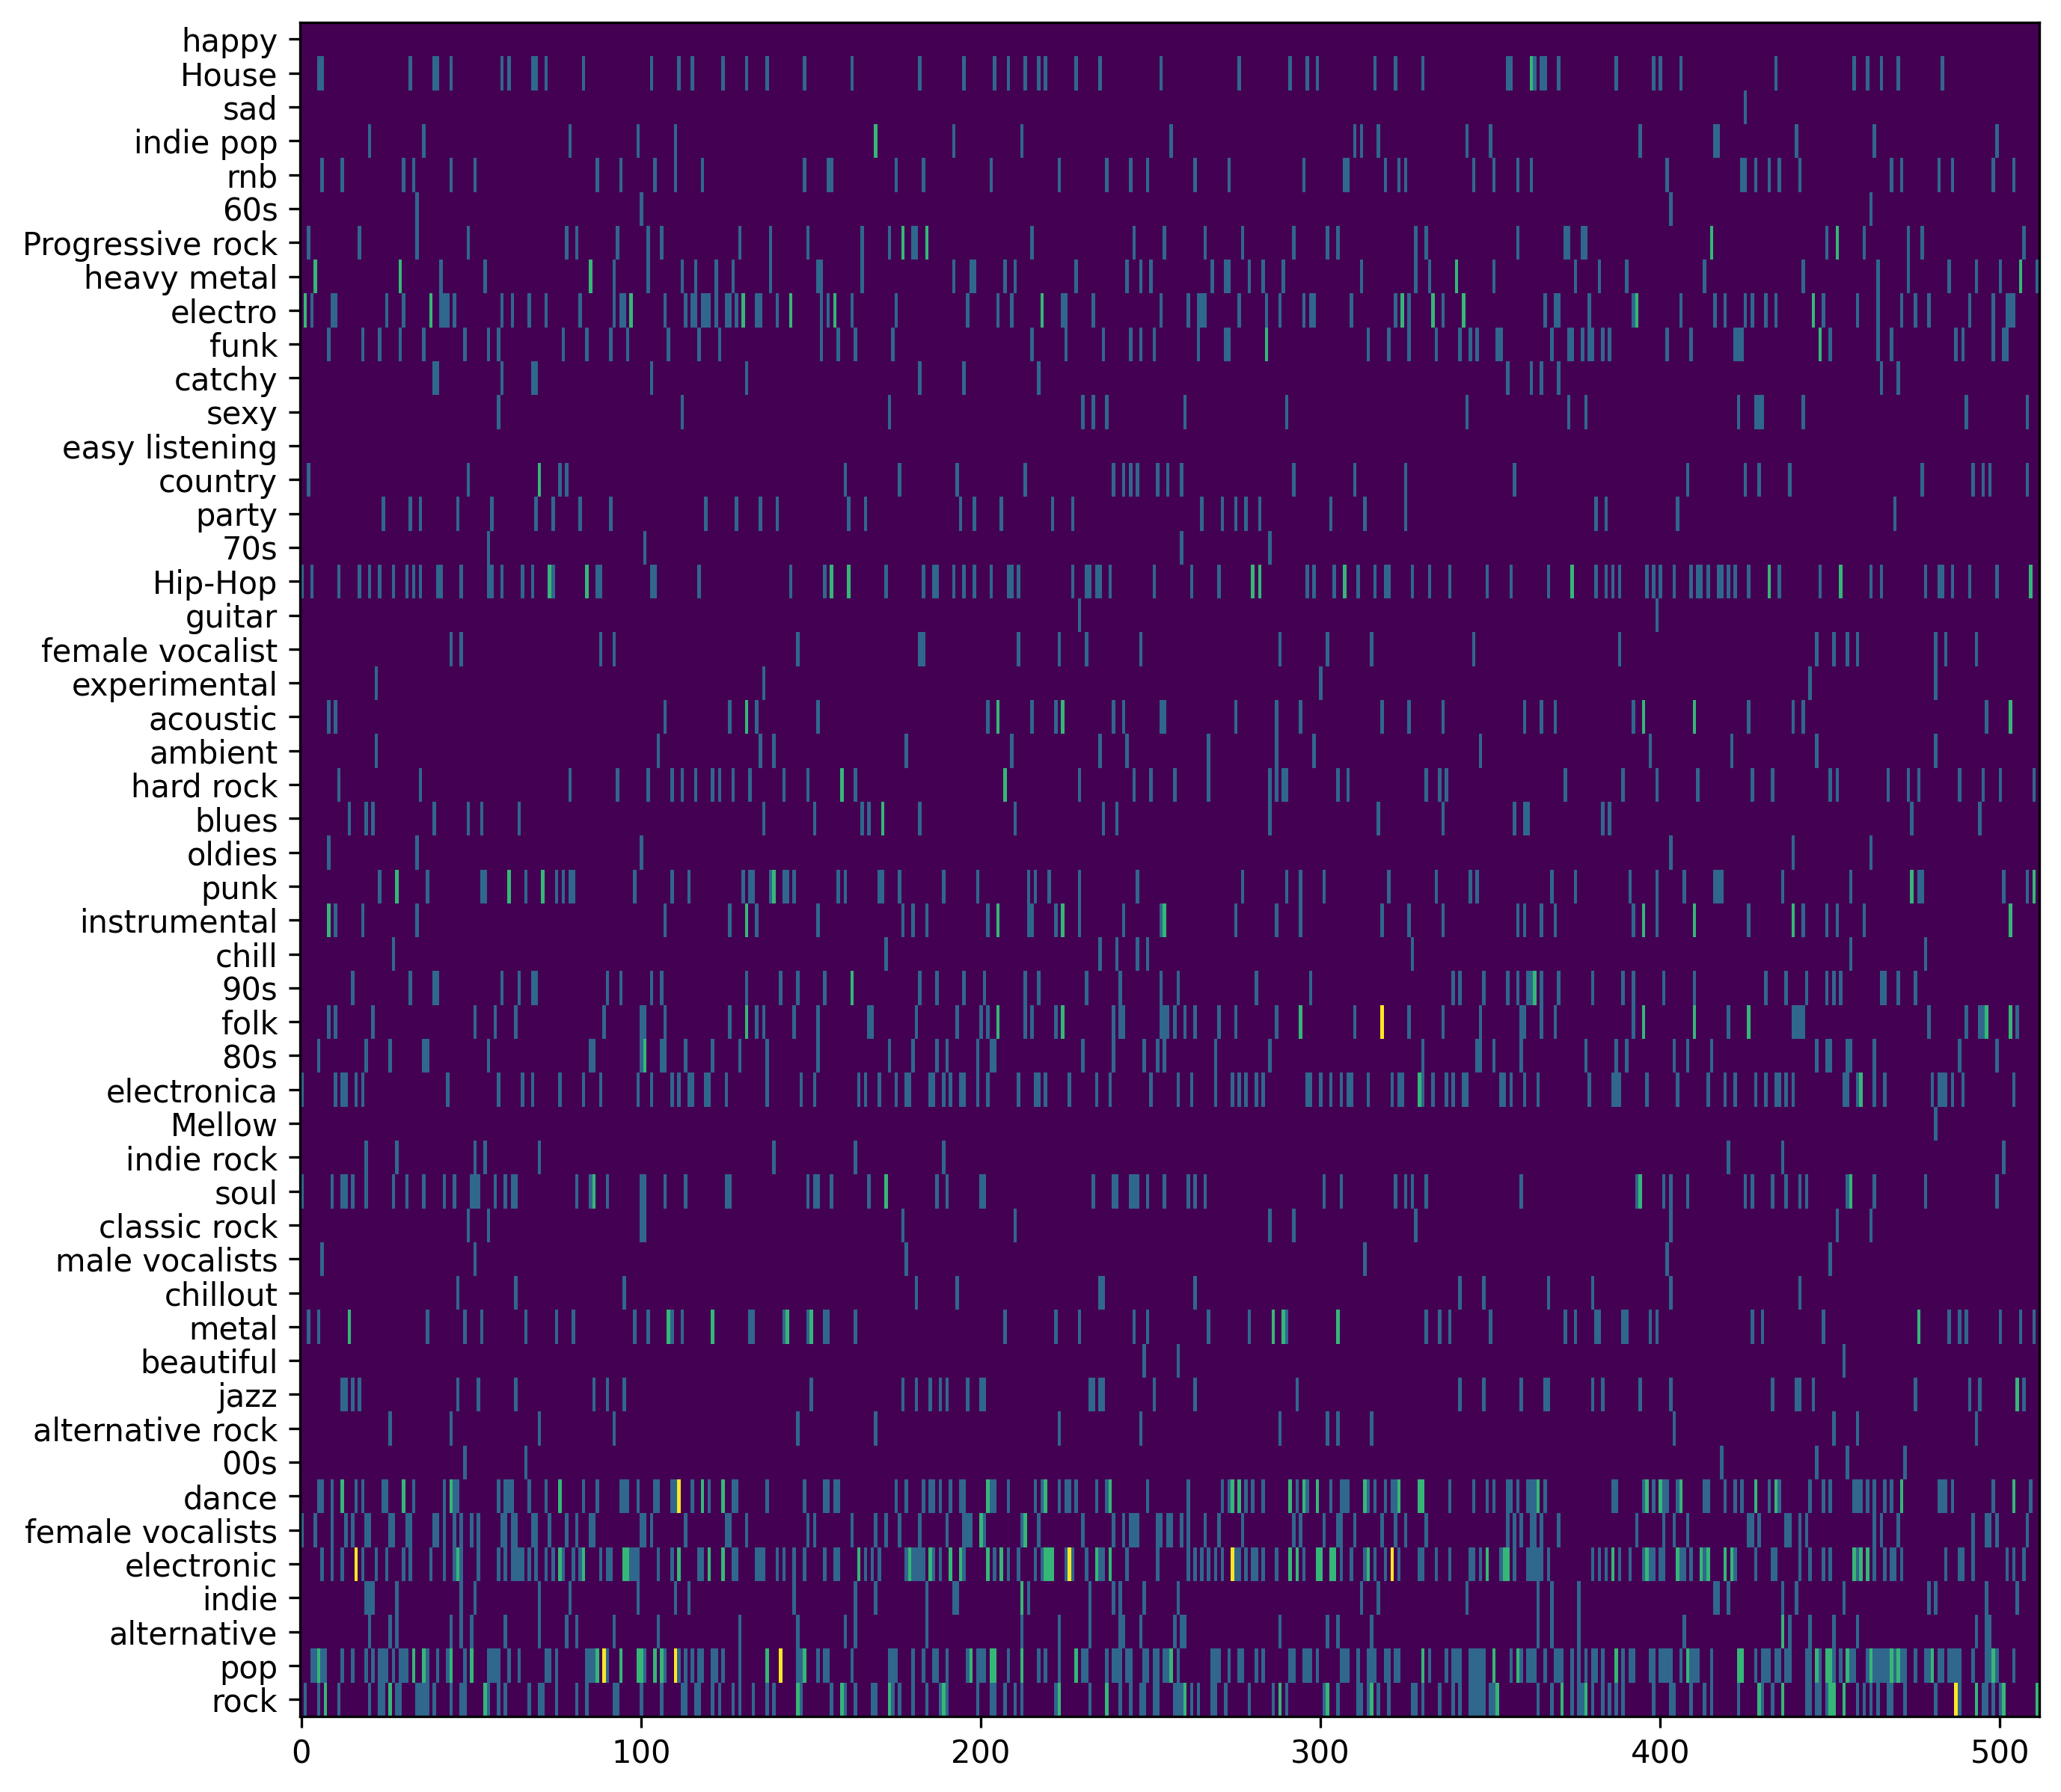

In [198]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
ax.imshow(np.array(all_tags_nums_list).T, interpolation='nearest', aspect='auto')
ax.set_yticks(np.arange(0,50,1))
ax.set_yticklabels(train_dataset.tags)
plt.gca().invert_yaxis()
plt.savefig("./media/features_tags_frequency.pdf")
plt.show()

In [204]:
for k, v in all_tags.items():
    if "House" in v:
        print(k, v)
        print()

5 ['rock', 'pop', '80s', 'pop', 'dance', 'House', 'metal']

6 ['pop', 'dance', 'rnb', 'male vocalists', 'electronic', 'House']

32 ['female vocalists', '90s', 'House', 'party', 'electronic']

39 ['rock', 'blues', 'female vocalists', '90s', 'catchy', 'House']

40 ['Hip-Hop', 'pop', 'female vocalists', '90s', 'catchy', 'House']

44 ['pop', 'dance', 'House', 'rock', 'alternative', 'alternative rock', 'female vocalist', 'pop', 'dance', 'rnb']

59 ['female vocalists', '90s', 'catchy', 'House', 'electro', 'Hip-Hop']

61 ['pop', 'dance', 'House', 'punk', 'punk']

68 ['electronica', 'Hip-Hop', 'female vocalists', '90s', 'catchy', 'House']

69 ['party', 'electronic', 'female vocalists', '90s', 'catchy', 'House']

72 ['electro', 'pop', 'dance', 'House', 'electronic']

83 ['electronica', 'electronic', 'dance', 'electronic', 'House']

103 ['Hip-Hop', 'female vocalists', '90s', 'catchy', 'House', 'electronica']

111 ['pop', 'dance', 'House', 'electronic', 'dance', 'electronica', 'electronic', 'danc

## audioLIME

In [20]:
print(train_dataset.index[0][3])

./datasets/magnatagatune/processed/train/1-22050.wav


In [21]:
from IPython.display import Audio


fp = "./original.wav"
seconds = 5

start_sec = 10 * args.audio_length
end_sec = start_sec + seconds * args.audio_length

audio, sr = torchaudio.load("./datasets/magnatagatune/processed/train/1-22050.wav")
new_audio = audio[:, start_sec:end_sec]
torchaudio.save(fp, new_audio, sample_rate=sr)
Audio(new_audio.numpy(), rate=sr)


In [43]:
import librosa
from audioLIME.data_provider import RawAudioProvider
from audioLIME.factorization import SpleeterFactorization
from audioLIME import lime_audio

In [44]:
data_provider = RawAudioProvider(fp)
spleeter_factorization = SpleeterFactorization(data_provider,
                                               n_temporal_segments=10,
                                               composition_fn=None,
                                               model_name='spleeter:5stems')

explainer = lime_audio.LimeAudioExplainer(verbose=True, absolute_feature_sort=False)

INFO:tensorflow:Apply unet for vocals_spectrogram
INFO:tensorflow:Apply unet for piano_spectrogram
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram
INFO:tensorflow:Restoring parameters from pretrained_models/5stems/model


/home/jspijkervet/miniconda3/lib/python3.7/site-packages/audioLIME-0.0.1-py3.7.egg/audioLIME/factorization.py:88: UserWarning: last 7 samples are ignored
  warnings.warn("last {} samples are ignored".format(audio_length - explained_length))


In [45]:
def predict(audio):
    audio = torch.from_numpy(audio).reshape(1,-1)
    audio = audio.to(args.device)
    audio = audio[:, :args.audio_length]
    audio = audio.unsqueeze(0)
    h = encoder(audio)
    output = finetuned_head(h)
    output = output.detach().cpu().numpy()
    return output

In [55]:
# predict_fn = model!!
explanation = explainer.explain_instance(factorization=spleeter_factorization,
                                         predict_fn=predict,
                                         top_labels=3,
                                         num_samples=args.audio_length,
                                         batch_size=1)

KeyboardInterrupt: 

In [ ]:
label = list(explanation.local_exp.keys())[0]
top_components, component_indeces = explanation.get_sorted_components(label,
                                                                      positive_components=True,
                                                                      negative_components=False,
                                                                      num_components=3,
                                                                      return_indeces=True)

print("predicted label:", label)
librosa.output.write_wav(os.path.join("explanation.wav"), sum(top_components), 16000)
librosa.output.write_wav(os.path.join("original.wav"), spleeter_factorization.data_provider.get_mix(), 16000)

In [ ]:
# TSNE

In [ ]:
# import seaborn as sns
# from sklearn.manifold import TSNE
# import pandas as pd

# def tsne(features):
#     embedding = TSNE().fit_transform(features)
#     return embedding

In [ ]:
# features = [f[1] for f in predictions]
# labels = np.array([f[2] for f in predictions])
# fps = [os.path.splitext(f[5])[0] + ".wav" for f in predictions]

In [ ]:
# embedding = tsne(features)

In [ ]:
# figure = plt.figure(figsize=(8, 8), dpi=120)
#     # plt.scatter(embedding[:, 0], embedding[:, 1], c=labels.ravel())

# labels = labels.squeeze()

# d = {"x": embedding[:, 0], "y": embedding[:, 1], "label": labels}
# df = pd.DataFrame(data=d)

# g = sns.scatterplot(
#     x="x",
#     y="y",
#     hue="label",
#     palette=sns.color_palette("hls", len(set(labels))),
# #     legend="full",
#     data=df,
#     alpha=1,
# )

# box = g.get_position()
# g.set_position([box.x0, box.y0, box.width * 0.85, box.height])  # resize position

# # Put a legend to the right side
# g.legend(loc="center right", bbox_to_anchor=(1.25, 0.5), ncol=1)

# plt.axis("off")
# #     plt.savefig(fp, bbox_inches="tight")
# plt.show()

In [ ]:
# import os
# import json
# import numpy as np
# import torchaudio
# from tqdm import tqdm
# from pathlib import Path
# import colorsys

# def tsne_to_json(audio_length, dataset, embedding, fps, labels):

#     vis_dir = os.path.join("visualisation", "audio")
#     if not os.path.exists(vis_dir):
#         os.makedirs(vis_dir)

#     x, y = embedding[:, 0], embedding[:, 1]

#     # between [0, 1]
#     x = (x - np.min(x)) / np.ptp(x)
#     y = (y - np.min(y)) / np.ptp(y)


#     all_d = {}
#     all_d["tsne"] = []
#     f = {}
#     f["names"] = []
#     f["filenames"] = []
#     f["colors"] = []

#     idx = 0
#     prev_track = None
#     for x, y, fp, label in tqdm(zip(x, y, fps, labels)):
#         audio_path = Path(fp)
#         track_name = audio_path.stem # _, fp, _ = tracks_list
#         c = {}
#         c["coordinates"] = [float(x), float(y)]
#         all_d["tsne"].append(c)
#         f["names"].append(track_name)

#         start_idx = idx * audio_length
#         f["filenames"].append(str(audio_path))  # dirty fix


# #         audio_fp = os.path.join(vis_dir, fn)
# #         if not os.path.exists(audio_fp):
# #             audio, sr = torchaudio.load(audio_path)
# #             audio = audio[:, start_idx : start_idx + audio_length]

# #             torchaudio.save(audio_fp, audio, sample_rate=sr)

#         idx += 1

#         if label != prev_track:
#             idx = 0
#             prev_track = label.item()


#     all_d["names"] = f["names"]
#     all_d["filenames"] = f["filenames"]

#     color_d = {}
#     unique_names = list(set(all_d["names"]))
#     colors = _get_colors(len(unique_names))
#     for k, v in zip(unique_names, colors):
#         color_d[k] = v


#     # all unique tracks
#     for k in all_d["names"]:
#         f["colors"].append(color_d[k])

#     all_d["colors"] = f["colors"]

#     with open("./validation/visualisation/data.json", "w") as f:
#         json.dump(all_d, f, ensure_ascii=False, indent=4)


# def _get_colors(num_colors):
#     colors = []
#     for i in np.arange(0.0, 360.0, 360.0 / num_colors):
#         hue = i / 360.0
#         lightness = (50 + np.random.rand() * 10) / 100.0
#         saturation = (90 + np.random.rand() * 10) / 100.0
#         colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
#     return colors


In [ ]:
# tsne_to_json(59049, test_dataset, embedding, fps, labels)